In [1]:
from pylabnet.hardware.awg.quantum_machine import Driver
from pylabnet.utils.logging.logger import LogClient
from configuration import config

# Note this may require special installs, but allows for convenient inline plot manipulation
# %matplotlib widget

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dev_id = 'QM_ford'

# Instantiate Logger
# OPTIONAL, only if log server exists
logger = LogClient(
    host='192.168.50.101', 
    port=38967,
    module_tag=f'Quantum Machine {dev_id}'
)

qmm = Driver(
    dev_id,
  logger=logger
)

2022-03-23 15:57:35,729 - qm - INFO - Performing health check
2022-03-23 15:57:35,732 - qm - INFO - Health check passed


In [3]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm.simulate import SimulationConfig
from configuration import config
import matplotlib.pyplot as plt
import numpy as np

tt_window_len = 100000  # 67000000
avgs = 100
f_min = 10e6; f_max = 200e6; df = 10e6; f_vec = np.arange(f_min, f_max, df)
config['pulses']['reset_pulse']['length'] = 300
config['pulses']['e_spin_const_pulse']['length'] = tt_window_len
config['waveforms']['e_spin_const_wf']['sample'] = 0.4
config['pulses']['res_readout_pulse']['length'] = tt_window_len


with program() as cw_odmr:

    f = declare(int)
    n = declare(int)
    times = declare(int, size=1000)  # 16000
    idx = declare(int)
    times_st = declare_stream()
    counts = declare(int)
    counts_st = declare_stream()

    with for_(n, 0, n < avgs, n+1):

        with for_(f, f_min, f < f_max, f+df):

            update_frequency('e_spin', f)
            play('reset', 'reset_laser')
            align()
            play('const', 'e_spin')
            play('readout', 'resonant_read_laser')
            measure('tt_window', 'snspd', None, time_tagging.analog(times, tt_window_len, counts))

            save(counts, counts_st)
            with for_(idx, 0, idx < counts, idx+1):
                save(times[idx], times_st)

    with stream_processing():
        counts_st.buffer(len(f_vec)).save_all('counts')
        times_st.save_all('times')



job = qmm.execute(config, cw_odmr)

# results handing
handles = job.result_handles
times_handle = handles.get('times')
counts_handle = job.result_handles.get('counts')
handles.wait_for_all_values()
times = times_handle.fetch_all()['value']
counts = counts_handle.fetch_all()['value']



2022-03-23 15:57:36,761 - qm - INFO - Flags: 
2022-03-23 15:57:36,762 - qm - INFO - Sending program to QOP
2022-03-23 15:57:36,812 - qm - INFO - Executing program


2022-03-23 15:57:37,640 - qm - INFO - Flags: 
2022-03-23 15:57:37,641 - qm - INFO - Simulating program


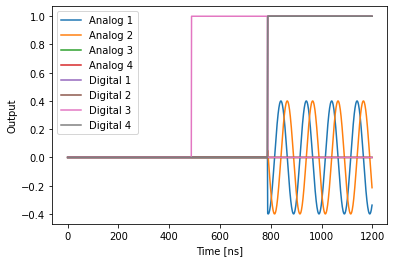

In [4]:
# simulation
job, samples = qmm.simulate(config, cw_odmr, duration=300)
samples.con1.plot()